#Distance Estimator
To estimate the real distance(unit: meter) of the object

__Input__: Bounding box coordinates(xmin, ymin, xmax, ymax)   
__Output__: 3D location z of carmera coordinates

In [1]:
!nvidia-smi

Tue Dec 12 10:16:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## Load Module

In [2]:
%cd /kaggle/working/
!ls

/kaggle/working


In [3]:
%%writefile custom_datasets.py
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# get data set
class CustomDataset():
    def __init__(self, data, variable, scaler=False, train=False):
        self.df=data
        self.inp = self.df[variable].values
        self.outp = self.df[['zloc']].values
        if train==True:
            self.scaler = StandardScaler().fit(self.inp)
        else: 
            self.scaler = train
        # Scaler
        if scaler==True:
            self.inp = self.scaler.transform(self.inp)
                
    def __len__(self):
        return len(self.inp) # 1314
    
    def __getitem__(self,idx):
        inp = torch.FloatTensor(self.inp[idx])
        outp = torch.FloatTensor(self.outp[idx])
        return inp, outp 

Writing custom_datasets.py


In [4]:
%%writefile early_stopping.py
"""
@bmhungqb
"""
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Writing early_stopping.py


In [5]:
%cd /kaggle/working/
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader 
from sklearn.preprocessing import StandardScaler
from custom_datasets import CustomDataset
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder

/kaggle/working


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
os.makedirs('./weights', exist_ok=True)

## Dataset

In [7]:
# get data set
df_train = pd.read_csv('/kaggle/input/dataset-distane-estimate-kitti/iou_train.csv')
df_valid = pd.read_csv('/kaggle/input/dataset-distane-estimate-kitti/iou_valid.csv')
df_test = pd.read_csv('/kaggle/input/dataset-distane-estimate-kitti/iou_test.csv')

In [8]:
df_train

,Unnamed: 0,filename,class,xmin,ymin,xmax,ymax,angle,zloc,weather,depth_x,depth_mean,depth_y,depth_min,depth_median,depth_max,depth_mean_trim,width,height
0,6142,001150.png,Truck,670.500000,149.35594,742.871340,186.78688,3.04,71.59,clone,741,7.721305,184,5.135296,8.066543,9.804019,7.689227,72.371340,37.43094
1,482,000110.png,Car,557.085270,164.77954,590.911130,180.29369,-1.02,80.22,clone,575,9.787977,179,9.487015,9.812434,9.918779,9.809649,33.825860,15.51415
2,15893,002947.png,Car,389.736700,184.53830,441.125760,216.58354,-1.34,34.42,clone,389,4.736269,215,3.778310,3.231332,6.782291,3.413900,51.389060,32.04524
3,8778,001651.png,Car,657.857240,168.36122,760.743300,205.31885,2.98,34.05,clone,759,4.808442,201,2.010450,4.758797,8.164209,4.823367,102.886060,36.95763
4,32882,006039.png,Car,425.418460,171.49203,532.927730,257.45590,1.75,16.76,clone,488,2.294223,221,1.821436,1.982113,6.658547,2.007758,107.509270,85.96387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26098,30813,005654.png,Car,688.074000,174.46814,803.448800,259.98520,-1.77,16.14,clone,800,2.376355,238,1.843411,1.909149,6.295566,1.840246,115.374800,85.51706
26099,16473,003042.png,Cyclist,667.827600,159.74207,726.245300,219.74590,-2.47,20.92,clone,704,3.516689,167,2.389574,2.873597,8.546009,2.864978,58.417700,60.00383
26100,23436,004332.png,Car,582.633700,168.72162,638.120500,224.25133,-1.59,23.82,clone,632,3.432011,185,2.810252,3.020881,9.402097,3.030918,55.486800,55.52971
26101,21207,003925.png,Car,578.589800,180.45372,644.207030,229.85207,-1.70,22.71,clone,643,3.171076,216,2.405436,2.626303,8.296898,2.648588,65.617230,49.39835


In [9]:
# sort the z_loc values
df_train['zloc'].sort_values()

24252      2.88
10803      2.93
22145      2.95
208        3.03
14678      3.07
          ...  
12455    101.70
7596     103.74
10698    106.63
13117    112.40
12039    115.28
Name: zloc, Length: 26103, dtype: float64

In [10]:
df_train.isna().sum(axis=0)

Unnamed: 0         0
filename           0
class              0
xmin               0
ymin               0
xmax               0
ymax               0
angle              0
zloc               0
weather            0
depth_x            0
depth_mean         0
depth_y            0
depth_min          0
depth_median       0
depth_max          0
depth_mean_trim    0
width              0
height             0
dtype: int64

In [11]:
df_valid.isna().sum(axis=0)

Unnamed: 0         0
filename           0
class              0
xmin               0
ymin               0
xmax               0
ymax               0
angle              0
zloc               0
weather            0
depth_x            0
depth_mean         0
depth_y            0
depth_min          0
depth_median       0
depth_max          0
depth_mean_trim    0
width              0
height             0
dtype: int64

In [12]:
df_test.isna().sum(axis=0)

Unnamed: 0         0
filename           0
class              0
xmin               0
ymin               0
xmax               0
ymax               0
angle              0
zloc               0
weather            0
depth_x            0
depth_mean         0
depth_y            0
depth_min          0
depth_median       0
depth_max          0
depth_mean_trim    0
width              0
height             0
dtype: int64

In [13]:
df_train = df_train[df_train['zloc'] > 0]
df_valid = df_valid[df_valid['zloc'] > 0]
df_test = df_test[df_test['zloc'] > 0]

In [14]:
#check the class
df_train['class'].unique()

array(['Truck', 'Car', 'Pedestrian', 'Van', 'Cyclist', 'Tram',
       'Person_sitting', 'Misc'], dtype=object)

In [15]:
df_train

,Unnamed: 0,filename,class,xmin,ymin,xmax,ymax,angle,zloc,weather,depth_x,depth_mean,depth_y,depth_min,depth_median,depth_max,depth_mean_trim,width,height
0,6142,001150.png,Truck,670.500000,149.35594,742.871340,186.78688,3.04,71.59,clone,741,7.721305,184,5.135296,8.066543,9.804019,7.689227,72.371340,37.43094
1,482,000110.png,Car,557.085270,164.77954,590.911130,180.29369,-1.02,80.22,clone,575,9.787977,179,9.487015,9.812434,9.918779,9.809649,33.825860,15.51415
2,15893,002947.png,Car,389.736700,184.53830,441.125760,216.58354,-1.34,34.42,clone,389,4.736269,215,3.778310,3.231332,6.782291,3.413900,51.389060,32.04524
3,8778,001651.png,Car,657.857240,168.36122,760.743300,205.31885,2.98,34.05,clone,759,4.808442,201,2.010450,4.758797,8.164209,4.823367,102.886060,36.95763
4,32882,006039.png,Car,425.418460,171.49203,532.927730,257.45590,1.75,16.76,clone,488,2.294223,221,1.821436,1.982113,6.658547,2.007758,107.509270,85.96387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26098,30813,005654.png,Car,688.074000,174.46814,803.448800,259.98520,-1.77,16.14,clone,800,2.376355,238,1.843411,1.909149,6.295566,1.840246,115.374800,85.51706
26099,16473,003042.png,Cyclist,667.827600,159.74207,726.245300,219.74590,-2.47,20.92,clone,704,3.516689,167,2.389574,2.873597,8.546009,2.864978,58.417700,60.00383
26100,23436,004332.png,Car,582.633700,168.72162,638.120500,224.25133,-1.59,23.82,clone,632,3.432011,185,2.810252,3.020881,9.402097,3.030918,55.486800,55.52971
26101,21207,003925.png,Car,578.589800,180.45372,644.207030,229.85207,-1.70,22.71,clone,643,3.171076,216,2.405436,2.626303,8.296898,2.648588,65.617230,49.39835


In [16]:
variable = ['xmin','ymin','xmax','ymax','width', 'height','depth_mean_trim','depth_mean','depth_max','depth_median']
val_length = len(variable)
batch_sz = 64
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    # Set the current device to the first GPU
    device = torch.device("cuda:0")
    # If there are multiple GPUs, you can set the current device to 'cuda:0' and use DataParallel
    if num_gpus > 1:
        device = torch.device("cuda:0")
        print(f"Using {num_gpus} GPUs.")
    else:
        print("Using a single GPU.")
else:
    device = torch.device("cpu")

# train
train_dataset = CustomDataset(df_train, variable, scaler=True, train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
# train_sclaer
scaler_train = train_dataset.scaler

# valid
valid_dataset = CustomDataset(df_valid, variable, True, train=scaler_train)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, shuffle=True)

# test
test_dataset = CustomDataset(df_test, variable, True, train=scaler_train)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(df_test), shuffle=False)

Using 2 GPUs.


In [17]:
from pickle import dump
# scaler
dump(scaler_train, open('/kaggle/working/weights/lstm_scaler.pkl', 'wb'))

In [19]:
# look the dataset
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    print(batch[0])
    print(batch[0].shape)
    print(batch[0].dtype)
    print(batch[1])

tensor([[-1.8766,  0.5172, -1.7060,  2.2447,  0.5462,  1.8606, -1.1885, -1.3463,
         -2.0886, -1.1606],
        [ 0.5429,  0.0261,  0.2183, -0.6315, -0.9700, -0.5914,  0.5273,  0.3494,
         -0.5454,  0.5209],
        [ 0.2849, -0.0183,  0.0265, -0.8028, -0.7692, -0.7314,  0.8290,  0.7866,
          1.2555,  0.8311],
        [-1.1222,  0.4964, -0.9765, -0.1887,  0.4555, -0.3702, -0.3844, -0.5012,
          0.7990, -0.3524],
        [-1.8773,  0.8436, -1.8975,  1.6715, -0.0168,  1.2041, -0.9868, -1.0888,
         -1.4753, -0.9715],
        [-1.0133,  0.4669, -0.3227,  2.2271,  2.0608,  1.8643, -1.1771, -1.2353,
         -0.4568, -1.1664],
        [ 0.1381,  0.3062, -0.0113, -0.3432, -0.4442, -0.4370, -0.3802, -0.1292,
          0.0974, -0.3485],
        [ 0.4523,  0.3093,  0.1761, -0.8710, -0.8254, -0.9238,  1.6138,  1.5367,
          0.8209,  1.5951],
        [-0.1493,  0.5832, -0.4101, -0.7047, -0.7662, -0.8793,  1.1268,  1.0861,
          0.6356,  1.1129],
        [ 0.4471,  

## Modeling

In [20]:
# zloc estimator model
class Distance_Estimator(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim=1):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim,
                           batch_first=True, bidirectional=False)
        
        #Layer
        layersize=[306, 154, 76]
        layerlist= []
        n_in=hidden_dim
        for i in layersize:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU())
            n_in=i           
        layerlist.append(nn.Linear(layersize[-1],1))        
        self.fc=nn.Sequential(*layerlist)

        
    def forward(self, x):
        out, hn = self.rnn(x)
        output = self.fc(out[:,-1])
        return output

## Make  variable

In [21]:

import torch.nn.init as init
input_dim = val_length
hidden_dim = 612
layer_dim = 3
        
model = Distance_Estimator(input_dim, hidden_dim, layer_dim)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.5,
                                                       patience = 10,
                                                       mode='min',
                                                       verbose=True,
                                                       min_lr=5e-5)
from early_stopping import EarlyStopping
early_stopping = EarlyStopping(70, verbose=True)   

model.to(device)

Distance_Estimator(
  (rnn): LSTM(10, 612, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=612, out_features=306, bias=True)
    (1): ReLU()
    (2): Linear(in_features=306, out_features=154, bias=True)
    (3): ReLU()
    (4): Linear(in_features=154, out_features=76, bias=True)
    (5): ReLU()
    (6): Linear(in_features=76, out_features=1, bias=True)
  )
)

In [22]:
# train parameters
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameter(model)

7776761

## Make Train, Valid function

In [23]:
def train(model, train_dataloader, idx_interval):
    model.train()
    
    train_loss = 0
    train_rmse = 0
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        inp = batch[0].reshape(len(batch[0]),1,-1)
        
        prediction = model(inp.to(device))
        loss = loss_fn(prediction, batch[1].to(device)).cpu()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        if idx % idx_interval == 0:
            print("Train Epoch: {} [{}/{}] \t Train Loss(MAE): {:.4f} \t Train RMAE: {:.4f}".format(epoch, batch_sz*(idx+1), \
                                                                            len(train_dataloader)*batch_sz, \
                                                                            loss.item(), np.sqrt(loss.item())))
    
    train_loss /= len(train_dataloader)
    train_rmse = np.sqrt(train_loss)
        
    return train_loss, train_rmse

In [24]:
def evaluate(model, valid_dataloader):
    model.eval()
    
    valid_loss = 0
    valid_rmse = 0
    
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            inp = batch[0].reshape(len(batch[0]),1,-1)
            predictions = model(inp.to(device))
            loss = loss_fn(predictions, batch[1].to(device)).cpu()
            valid_loss += loss.item()
            
    valid_loss /= len(valid_dataloader)
    valid_rmse = np.sqrt(valid_loss)
    
    return valid_loss,valid_rmse

## Train and Validation

In [26]:
# training
Epoch = 500
best_mae = 99999
best_train_mae = 99999

train_mae_list = []
valid_mae_list = []


for epoch in range(1,(Epoch+1)):
    train_mae, train_rmae = train(model, train_dataloader, 200)
    valid_mae, valid_rmae = evaluate(model, valid_dataloader)

    print("[Epoch: {} \t Valid MAE: {:.4f}".format(epoch, valid_mae))
    print("[Epoch: {} \t Train MAE: {:.4f}".format(epoch, train_mae))
    
    scheduler.step(valid_mae)       
    # Save model
    if valid_mae < best_mae:
        path = "./weights/lstm_model.pth"
        torch.save(model.state_dict(), path)
        best_mae = valid_mae
        best_train_mae = train_mae
        
    train_mae_list.append(train_mae)
    valid_mae_list.append(valid_mae)
    
    early_stopping(valid_mae, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Train Epoch: 1 [64/26112] 	 Train Loss(MAE): 2.3677 	 Train RMAE: 1.5387
Train Epoch: 1 [12864/26112] 	 Train Loss(MAE): 4.1184 	 Train RMAE: 2.0294
Train Epoch: 1 [25664/26112] 	 Train Loss(MAE): 2.0701 	 Train RMAE: 1.4388
[Epoch: 1 	 Valid MAE: 2.2749
[Epoch: 1 	 Train MAE: 2.4984
Validation loss decreased (2.296333 --> 2.274882).  Saving model ...
Train Epoch: 2 [64/26112] 	 Train Loss(MAE): 2.9629 	 Train RMAE: 1.7213
Train Epoch: 2 [12864/26112] 	 Train Loss(MAE): 2.3949 	 Train RMAE: 1.5476
Train Epoch: 2 [25664/26112] 	 Train Loss(MAE): 2.6888 	 Train RMAE: 1.6397
[Epoch: 2 	 Valid MAE: 1.9878
[Epoch: 2 	 Train MAE: 2.3645
Validation loss decreased (2.274882 --> 1.987810).  Saving model ...
Train Epoch: 3 [64/26112] 	 Train Loss(MAE): 1.9893 	 Train RMAE: 1.4104
Train Epoch: 3 [12864/26112] 	 Train Loss(MAE): 3.0442 	 Train RMAE: 1.7448
Train Epoch: 3 [25664/26112] 	 Train Loss(MAE): 1.4233 	 Train RMAE: 1.1930
[Epoch: 3 	 Valid MAE: 2.1958
[Epoch: 3 	 Train MAE: 2.2751
EarlySt

In [27]:
print('Valid best:',best_mae)
print('Train best:',best_train_mae)

Valid best: 1.1429130072687186
Train best: 0.7712854650967261


# Epoch visualization

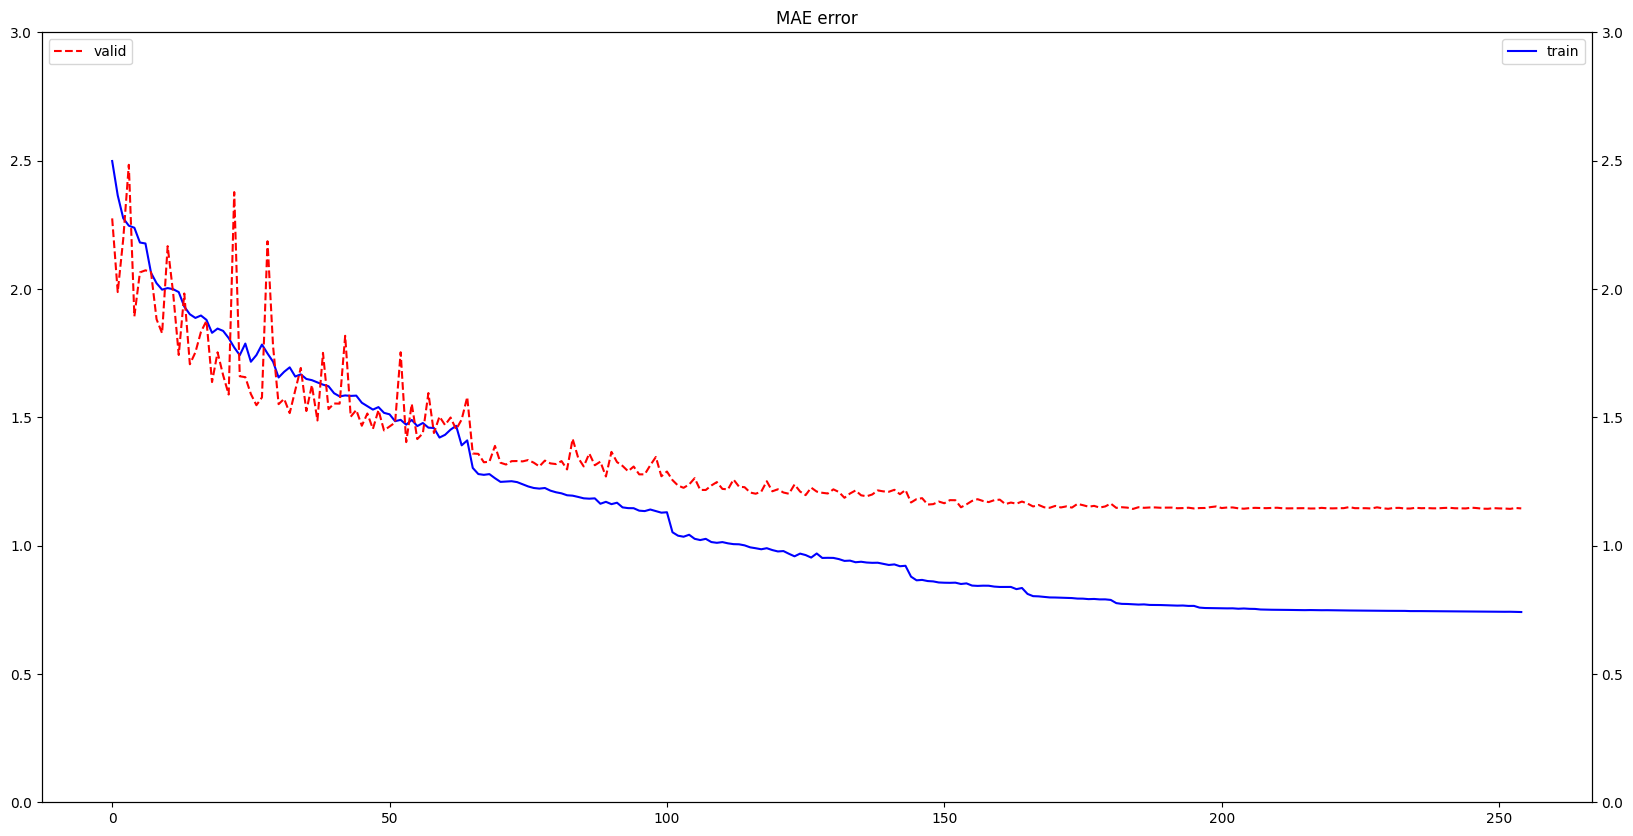

In [63]:
# visualizing
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(train_mae_list, ls='-', color='blue', label='train')
ax1.set_ylim(0,3)

ax2 = ax1.twinx()
ax2.plot(valid_mae_list, ls='--', color='red', label='valid')
ax2.set_ylim(0,3)

ax1.set_title('MAE error')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

# Best performance

In [64]:
# get weights
model = Distance_Estimator(input_dim, hidden_dim,layer_dim)
model.load_state_dict(torch.load('./weights/lstm_model.pth'))
model.eval()
model.to(device)

Distance_Estimator(
  (rnn): LSTM(10, 612, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=612, out_features=306, bias=True)
    (1): ReLU()
    (2): Linear(in_features=306, out_features=154, bias=True)
    (3): ReLU()
    (4): Linear(in_features=154, out_features=76, bias=True)
    (5): ReLU()
    (6): Linear(in_features=76, out_features=1, bias=True)
  )
)

# Predict Train

In [65]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(df_train), shuffle=False)
for idx, batch in enumerate(train_dataloader):
    if idx == 1:
        break
    train_pred = batch[0]
predict_zloc = model(train_pred.reshape(-1,1,input_dim).to(device))

In [66]:
df_train['predict'] = predict_zloc.cpu().detach().numpy()
df_train[['zloc','predict']].head(10)

/tmp/ipykernel_42/3425435218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['predict'] = predict_zloc.cpu().detach().numpy()


,zloc,predict
4,48.09,71.609116
30,32.43,79.611343
41,9.37,36.253368
58,37.82,33.471336
90,26.58,16.454918
92,7.07,29.595739
104,43.21,67.606155
118,66.09,11.971720
132,62.19,64.246048
142,43.45,10.558659


In [31]:
# calculate
import numpy as np
abs0 = np.abs(df_train.zloc-df_train.predict)
abs0

0        0.019116
1        0.608672
2        1.833368
3        0.578667
4        0.305086
           ...   
26098    0.281758
26099    1.574234
26100    0.121302
26101    0.796267
26102    0.350783
Length: 26103, dtype: float64

In [32]:
# mae
sum(abs0/len(df_train))

0.7655633443789195

In [33]:
# rmse
np.mean(np.square(df_train['zloc']-df_train['predict']))**(1/2)

2.1058508613888196

In [34]:
# accuracy
func = np.sum(np.abs((df_train.predict - df_train.zloc))/(df_train.predict))
men = func/len(df_train)
1-men

0.9711977637560565

# Predict Valid

In [35]:
# valid set
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=len(df_train), shuffle=False)
for idx, batch in enumerate(valid_dataloader):
    if idx == 1:
        break
    valid_pred = batch[0]
predict_zloc = model(valid_pred.reshape(-1,1,input_dim).to(device))

In [36]:
# estimate valid
df_valid['predict'] = predict_zloc.cpu().detach().numpy()
df_valid[['zloc','predict']].head(10)

,zloc,predict
0,11.15,11.230824
1,41.50,41.804409
2,24.17,24.604700
3,35.94,35.712772
4,10.83,11.050531
5,36.92,34.495800
6,25.10,24.720335
7,9.43,9.469545
8,13.85,14.077168
9,38.33,39.047859


In [37]:
abs0 = np.abs(df_valid.zloc-df_valid.predict)
abs0

0       0.080824
1       0.304409
2       0.434700
3       0.227228
4       0.220531
          ...   
3257    0.900149
3258    0.951438
3259    0.631634
3260    1.834403
3261    1.201801
Length: 3262, dtype: float64

In [38]:
# mae
sum(abs0/len(df_valid))

1.1428284937000792

In [39]:
#rmse
np.mean(np.square(df_valid['zloc']-df_valid['predict']))**(1/2)

2.4276795608315695

In [40]:
# accuracy
func = np.sum(np.abs((df_valid.predict - df_valid.zloc))/(df_valid.predict))
men = func/len(df_valid)
1-men

0.9555214845524247

# Predict Test

In [41]:
test_mse, test_rmse = evaluate(model, test_dataloader)
print('Test MAE: {:4f} \t Test RMAE: {:4f}'.format(test_mse, test_rmse))

Test MAE: 1.201929 	 Test RMAE: 1.096325


In [42]:
# look dataset
for idx, batch in enumerate(test_dataloader):
    if idx == 1:
        break
    test_pred = batch[0]
predict_zloc = model(test_pred.reshape(-1,1,input_dim).to(device))

In [43]:
df_test['predict'] = predict_zloc.cpu().detach().numpy()
df_test[['zloc','predict']].head(10)

,zloc,predict
0,73.41,71.486458
1,22.08,22.033094
2,76.20,75.203117
3,45.30,42.444019
4,48.09,48.273182
5,47.46,48.867748
6,8.41,8.588284
7,26.58,27.266050
8,9.24,9.434153
9,14.90,15.200146


In [44]:
import numpy as np
abs0 = np.abs(df_test.zloc-df_test.predict)
abs0

0       1.923542
1       0.046906
2       0.996883
3       2.855981
4       0.183182
          ...   
3259    1.094955
3260    0.014641
3261    0.328580
3262    0.415169
3263    1.366924
Length: 3264, dtype: float64

In [45]:
# mae
sum(abs0/len(df_test))

1.2019288631806195

In [46]:
# rmse
np.mean(np.square(df_test['zloc']-df_test['predict']))**(1/2)

2.8692870382465436

In [47]:
# accuracy
func = np.sum(np.abs((df_test.predict - df_test.zloc))/(df_test.predict))
men = func/len(df_test)
1-men

0.9518226141679321

In [48]:
df_test['class'].unique()

array(['Car', 'Truck', 'Van', 'Pedestrian', 'Cyclist', 'Person_sitting',
       'Tram', 'Misc'], dtype=object)

In [49]:
matrix = pd.DataFrame(columns=['type','RMSE','MAE','Accuracy'])
matrix

,type,RMSE,MAE,Accuracy


In [50]:
# Truck
truck = df_test['class']=='Truck'
df_truck = df_test[truck]

# mae
abs0 = np.abs(df_truck.zloc-df_truck.predict)
print(sum(abs0/len(df_truck))) # 1.8629
      
# rmse 
print(np.mean(np.square(df_truck['zloc']-df_truck['predict']))**(1/2)) # 3.2170

# accuracy
func = np.sum(np.abs((df_truck.predict - df_truck.zloc))/(df_truck.predict))
men = func/len(df_truck)
print(1-men) # 0.9376

matrix.loc[0,'type'] = 'Truck'
matrix.loc[0,'RMSE'] = round(np.mean(np.square(df_truck['zloc']-df_truck['predict']))**(1/2),4)
matrix.loc[0,'MAE'] = round(sum(abs0/len(df_truck)),4)
matrix.loc[0,'Accuracy'] = round(1-men,4)
matrix

1.4844431055206617
3.4974685312081535
0.9605969800319697


,type,RMSE,MAE,Accuracy
0,Truck,3.4975,1.4844,0.9606


In [51]:
# car
car = df_test['class']=='Car'
df_car = df_test[car]

# mae
abs0 = np.abs(df_car.zloc-df_car.predict)
print(sum(abs0/len(df_car))) # 1.2531
      
# rmse 
print(np.mean(np.square(df_car['zloc']-df_car['predict']))**(1/2)) # 2.2713

# accuracy
func = np.sum(np.abs((df_car.predict - df_car.zloc))/(df_car.predict))
men = func/len(df_car)
print(1-men) # 0.9519

matrix.loc[1,'type'] = 'Car'
matrix.loc[1,'RMSE'] = round(np.mean(np.square(df_car['zloc']-df_car['predict']))**(1/2),4)
matrix.loc[1,'MAE'] = round(sum(abs0/len(df_car)),4)
matrix.loc[1,'Accuracy'] = round(1-men,4)

1.1581840113902775
3.0301865830902357
0.9536600351384275


In [52]:
# person
person = df_test['class']=='Pedestrian'
df_person = df_test[person]

# mae
abs0 = np.abs(df_person.zloc-df_person.predict)
print(sum(abs0/len(df_person))) # 0.7012
      
# rmse 
print(np.mean(np.square(df_person['zloc']-df_person['predict']))**(1/2)) # 1.2880

# accuracy
func = np.sum(np.abs((df_person.predict - df_person.zloc))/(df_person.predict))
men = func/len(df_person)
print(1-men) # 0.9529

matrix.loc[2,'type'] = 'Pedestrian'
matrix.loc[2,'RMSE'] = round(np.mean(np.square(df_person['zloc']-df_person['predict']))**(1/2),4)
matrix.loc[2,'MAE'] = round(sum(abs0/len(df_person)),4)
matrix.loc[2,'Accuracy'] = round(1-men,4)

0.7829133267238224
1.6355795536599296
0.9568187583015592


In [53]:
# Van
train = df_test['class']=='Van'
df_train = df_test[train] 

# mae
abs0 = np.abs(df_train.zloc-df_train.predict)
print(sum(abs0/len(df_train)))  # 1.6821
      
# rmse 
print(np.mean(np.square(df_train['zloc']-df_train['predict']))**(1/2)) # 2.3989

# accuracy
func = np.sum(np.abs((df_train.predict - df_train.zloc))/(df_train.predict))
men = func/len(df_train)
print(1-men) # 0.8611

matrix.loc[3,'type'] = 'Van'
matrix.loc[3,'RMSE'] = round(np.mean(np.square(df_train['zloc']-df_train['predict']))**(1/2),4)
matrix.loc[3,'MAE'] = round(sum(abs0/len(df_train)),4)
matrix.loc[3,'Accuracy'] = round(1-men,4)

2.0738795154094682
3.32259406488358
0.9359776498837414


In [54]:
# misc
misc = df_test['class']=='Misc'
df_misc = df_test[misc] 

# mae
abs0 = np.abs(df_misc.zloc-df_misc.predict)
print(sum(abs0/len(df_misc)))  # 1.2972
      
# rmse 
print(np.mean(np.square(df_misc['zloc']-df_misc['predict']))**(1/2)) # 1.7389

# accuracy
func = np.sum(np.abs((df_misc.predict - df_misc.zloc))/(df_misc.predict))
men = func/len(df_misc)
print(1-men) # 0.9384

matrix.loc[4,'type'] = 'Misc'
matrix.loc[4,'RMSE'] = round(np.mean(np.square(df_misc['zloc']-df_misc['predict']))**(1/2),4)
matrix.loc[4,'MAE'] = round(sum(abs0/len(df_misc)),4)
matrix.loc[4,'Accuracy'] = round(1-men,4)

1.3374670126563621
2.082981459566981
0.9402009516947851


In [55]:
# Cyclist
bicycle = df_test['class']=='Cyclist'
df_bicycle = df_test[bicycle] 

# mae
abs0 = np.abs(df_bicycle.zloc-df_bicycle.predict)
print(sum(abs0/len(df_bicycle)))  # 1.0336
      
# rmse 
print(np.mean(np.square(df_bicycle['zloc']-df_bicycle['predict']))**(1/2)) # 1.1845

# accuracy
func = np.sum(np.abs((df_bicycle.predict - df_bicycle.zloc))/(df_bicycle.predict))
men = func/len(df_bicycle)
print(1-men) # 0.9392

matrix.loc[5,'type'] = 'Cyclist'
matrix.loc[5,'RMSE'] = round(np.mean(np.square(df_bicycle['zloc']-df_bicycle['predict']))**(1/2),4)
matrix.loc[5,'MAE'] = round(sum(abs0/len(df_bicycle)),4)
matrix.loc[5,'Accuracy'] = round(1-men,4)

1.0942258212740057
1.6678602926674388
0.938864501631802


In [56]:
# Person_sitting
bicycle = df_test['class']=='Person_sitting'
df_bicycle = df_test[bicycle] 

# mae
abs0 = np.abs(df_bicycle.zloc-df_bicycle.predict)
print(sum(abs0/len(df_bicycle)))  # 1.0336
      
# rmse 
print(np.mean(np.square(df_bicycle['zloc']-df_bicycle['predict']))**(1/2)) # 1.1845

# accuracy
func = np.sum(np.abs((df_bicycle.predict - df_bicycle.zloc))/(df_bicycle.predict))
men = func/len(df_bicycle)
print(1-men) # 0.9392

matrix.loc[6,'type'] = 'Person_sitting'
matrix.loc[6,'RMSE'] = round(np.mean(np.square(df_bicycle['zloc']-df_bicycle['predict']))**(1/2),4)
matrix.loc[6,'MAE'] = round(sum(abs0/len(df_bicycle)),4)
matrix.loc[6,'Accuracy'] = round(1-men,4)

1.4534618403116861
3.028346086648422
0.9066300069874211


In [57]:
# Tram
bicycle = df_test['class']=='Tram'
df_bicycle = df_test[bicycle] 

# mae
abs0 = np.abs(df_bicycle.zloc-df_bicycle.predict)
print(sum(abs0/len(df_bicycle)))  # 1.0336
      
# rmse 
print(np.mean(np.square(df_bicycle['zloc']-df_bicycle['predict']))**(1/2)) # 1.1845

# accuracy
func = np.sum(np.abs((df_bicycle.predict - df_bicycle.zloc))/(df_bicycle.predict))
men = func/len(df_bicycle)
print(1-men) # 0.9392

matrix.loc[7,'type'] = 'Tram'
matrix.loc[7,'RMSE'] = round(np.mean(np.square(df_bicycle['zloc']-df_bicycle['predict']))**(1/2),4)
matrix.loc[7,'MAE'] = round(sum(abs0/len(df_bicycle)),4)
matrix.loc[7,'Accuracy'] = round(1-men,4)

1.4596585133870448
1.9569119228836
0.9633662000599112


In [58]:
# DataFrame
matrix

,type,RMSE,MAE,Accuracy
0,Truck,3.4975,1.4844,0.9606
1,Car,3.0302,1.1582,0.9537
2,Pedestrian,1.6356,0.7829,0.9568
3,Van,3.3226,2.0739,0.936
4,Misc,2.083,1.3375,0.9402
5,Cyclist,1.6679,1.0942,0.9389
6,Person_sitting,3.0283,1.4535,0.9066
7,Tram,1.9569,1.4597,0.9634


In [59]:
matrix.set_index('type', inplace=True)
matrix.loc[['Misc','Truck','Car','Pedestrian','Van','Cyclist','Person_sitting','Tram'],['RMSE','MAE','Accuracy']]

,RMSE,MAE,Accuracy
type,,,
Misc,2.083,1.3375,0.9402
Truck,3.4975,1.4844,0.9606
Car,3.0302,1.1582,0.9537
Pedestrian,1.6356,0.7829,0.9568
Van,3.3226,2.0739,0.936
Cyclist,1.6679,1.0942,0.9389
Person_sitting,3.0283,1.4535,0.9066
Tram,1.9569,1.4597,0.9634


# Calculating Metrics Based on Other Papers

In [67]:
performance = pd.DataFrame(index=['LSTM'])

In [68]:
# Abs Relative difference (Abs Rel)
Abs_rel = np.sum(np.abs(df_test.predict - df_test.zloc)/df_test.zloc)/len(df_test)
print('Abs_rel', Abs_rel) 
performance['Abs_rel'] = round(Abs_rel,3)

Abs_rel 0.04999145271669729


In [69]:
Squa_rel = np.sum((df_test.predict - df_test.zloc)**2/df_test.zloc)/len(df_test)
print('Squa_rel:',Squa_rel) 
performance['Squa_rel'] = round(Squa_rel,3)

Squa_rel: 0.2839704546633655


In [70]:
RMSE_log = np.sum(np.sqrt(((np.log(df_test.predict)-np.log(df_test.zloc))**2))/len(df_test))
print('RMSE_log', RMSE_log)
performance['RMSE_log'] = round(RMSE_log,3)

RMSE_log 0.04742076623105555


In [71]:
def threshold(delta):
    percentage = 0
    for i in range(len(df_test)):
        max_value = max(df_test.loc[i,'zloc']/df_test.loc[i,'predict'], \
                        df_test.loc[i,'predict']/df_test.loc[i,'zloc'])
        
        if max_value < delta:
            percentage += 1
    return percentage/len(df_test)

percentage_1 = round(threshold(1.25),3)
percentage_2 = round(threshold(1.25**2),3)
percentage_3 = round(threshold(1.25**3),3)
print('Delta 1.25', percentage_1)
print('Delta 1.25^2', percentage_2)
print('Delta 1.25^3', percentage_3)


performance['delta_1.25'] = round(percentage_1,3)
performance['delta_1.25^2'] = round(percentage_2,3)
performance['delta_1.25^3'] = round(percentage_3,3)

Delta 1.25 0.977
Delta 1.25^2 0.99
Delta 1.25^3 0.995


In [72]:
performance

,Abs_rel,Squa_rel,RMSE_log,delta_1.25,delta_1.25^2,delta_1.25^3
LSTM,0.05,0.284,0.047,0.977,0.99,0.995


## Divide by distance range and calculate it

In [73]:
first = df_test[df_test['zloc']<=10]
func1 = np.sum(np.abs((first.predict - first.zloc))/(first.predict))
men1 = func1/len(first)
1-men1

0.9094809693177136

In [74]:
mask = (df_test['zloc']>=10) & (df_test['zloc']<20)
second = df_test[mask]
func2 = np.sum(np.abs((second.predict - second.zloc))/(second.predict))
men2 = func2/len(second)
1-men2

0.9641281818621525

In [75]:
mask = (df_test['zloc']>=20) & (df_test['zloc']<30)
third = df_test[mask]
func3 = np.sum(np.abs((third.predict - third.zloc))/(third.predict))
men3 = func3/len(third)
1-men3

0.9612093617121666

In [76]:
mask = (df_test['zloc']>=30) & (df_test['zloc']<40)
fourth = df_test[mask]
func4 = np.sum(np.abs((fourth.predict - fourth.zloc))/(fourth.predict))
men4 = func4/len(fourth)
1-men4

0.9592773819009036

In [77]:
mask = (df_test['zloc']>=40) & (df_test['zloc']<50)
fifth = df_test[mask]
func5 = np.sum(np.abs((fifth.predict - fifth.zloc))/(fifth.predict))
men5 = func5/len(fifth)
1-men5

0.9627165096237498

In [78]:
mask = (df_test['zloc']>=50) & (df_test['zloc']<60)
sixth = df_test[mask]
func6 = np.sum(np.abs((sixth.predict - sixth.zloc))/(sixth.predict))
men6 = func6/len(sixth)
1-men6

0.9578672943433836

In [79]:
mask = (df_test['zloc']>=60) & (df_test['zloc']<70)
seventh = df_test[mask]
func7 = np.sum(np.abs((seventh.predict - seventh.zloc))/(seventh.predict))
men7 = func7/len(seventh)
1-men7

0.9171631359677587

In [80]:
acc_list = []
for i in range(1,12):
    mask = (df_test['zloc']<i*10) & (df_test['zloc'] >= (i-1)*10)
    data = df_test[mask]
    value = np.sum(np.abs((data.predict - data.zloc))/(data.predict))
    output = value/len(data)
    acc_list.append(1-output)

/tmp/ipykernel_42/2504621056.py:6: RuntimeWarning: invalid value encountered in scalar divide
  output = value/len(data)


In [81]:
acc_list

[0.9091156083473985,
 0.9641281818621525,
 0.9612093617121666,
 0.9592773819009036,
 0.9627165096237498,
 0.9578672943433836,
 0.9171631359677587,
 0.8958313564220484,
 0.9788523152342665,
 nan,
 nan]